# Adding-Doubling Basics

**Scott Prahl**

** September 2017 **

** version 1 **

## Overview

This Jupyter notebook shows some basic ways that the `iadpython` package can be used to do radiative transport calculations.

Adding-Doubling is inherently one-dimensional (but it can be layered).

In [1]:
# Execute this cell first
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

# if iadpython is missing, do `pip install iadpython`
import iadpython as iad

# needed only for one plot below
from scipy import optimize


## Total Reflection and Transmission

All angles are described by their cosines.  For example, the incidence angle $\nu$ is defined as the cosine of the angle between the direction of incidence and the normal to the slab.  

We define $R(\nu',\nu)$ as the fraction of light incident from the direction $\nu$ that is reflected at an angle $\nu'$.  Likewise $T(\nu',\nu)$ is the amount transmitted through the slab.

We are usually interested in the total reflection or transmission through the slab for normal (collimated) irradiance.
I adopt the nomenclature of van de Hulst (*Multiple Light Scattering*) and call this $\hbox{UR1}$ and $\hbox{UT1}$.  (Here the first U indicates light exiting at all angles and the 1 indicates the cosine of the angle of incidence.)  Specifically,
$$
\hbox{UR1} \equiv \int_0^1 R(\nu',1) \,2\nu' d\nu'
$$
and
$$
\hbox{UT1} \equiv \int_0^1 T(\nu',1) \,2\nu' d\nu'
$$
where the factor of two is a consequence of the fact that when $R(\nu',1)\equiv1$ then $\hbox{UR1}$=1.

The other quantity of interest is the total reflection or transmission for diffuse (Lambertian) incident light, $\hbox{URU}$ and $\hbox{UTU}$.  Specifically
$$
\hbox{URU} \equiv n^2 \int_0^1 \left[ \int_0^1 R(\nu',\nu) \,2\nu' d\nu'\right] 2\nu d\nu
$$
and
$$
\hbox{UTU} \equiv n^2 \int_0^1 \left[ \int_0^1 T(\nu',\nu) \,2\nu' d\nu' \right] 2\nu d\nu
$$
where, $n^2$ term is necessary to account for the $n^2$-law of radiance.

## Single scattering albedo

The albedo $a$ is defined as the ratio of scattering to scattering plus absorption.  If the scattering coefficient is $\mu_s$ and the absorption coefficient is $\mu_a$ then
$$
a = { \mu_s\over \mu_a+\mu_s }
$$
The handy thing about the albedo is that it is a dimensionless number that describes how scattering a sample is.  When $a=0$ there is no scattering at all and when $a=1$ there is no absorption.  Therefore as the scattering varies from 0 to 1, all possible cases can be described.

Consider an infinitely thick slab, we can plot the 1:1 correspondence between total reflectance and the albedo.

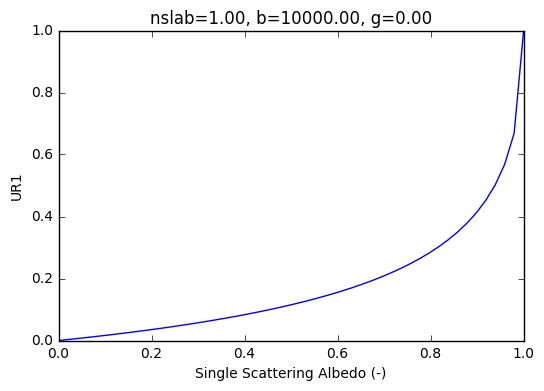

In [30]:
nslab=1.0                  # ignore boundary reflection
nslide=1.0                 # no glass slides above and below the sample
b=10000                    # this is pretty much infinite
g=0.0                      # isotropic scattering is fine
a = np.linspace(0,1,50)    # albedo varies between 0 and 1

ur1,ut1,uru,utu = iad.rt(nslab, nslide, a, b, g)

plt.plot(a,ur1,color='blue')
plt.xlabel('Single Scattering Albedo (-)')
plt.ylabel('UR1')
plt.title('nslab=%.2f, b=%.2f, g=%.2f'%(nslab,b,g))
plt.show()

Therefore if the total reflection from a thick slab is known, then the albedo is uniquely determined!

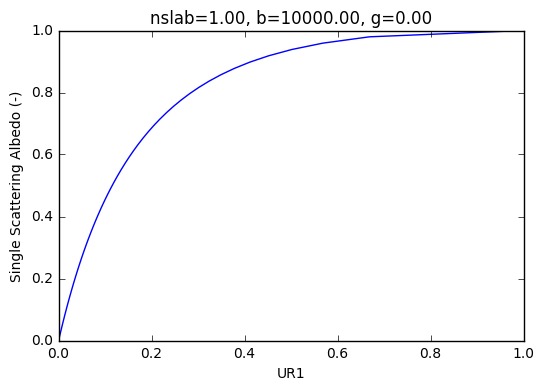

In [31]:
nslab=1.0                  # ignore boundary reflection
nslide=1.0                 # no glass slides above and below the sample
b=10000                    # this is pretty much infinite
g=0.0                      # isotropic scattering is fine
a = np.linspace(0,1,50)    # albedo varies between 0 and 1

ur1,ut1,uru,utu = iad.rt(nslab, nslide, a, b, g)

plt.plot(ur1,a,color='blue')
plt.ylabel('Single Scattering Albedo (-)')
plt.xlabel('UR1')
plt.title('nslab=%.2f, b=%.2f, g=%.2f'%(nslab,b,g))
plt.show()

## Optical Thickness

The optical thickness $b$ is the average number of scattering or absorption events that take place as light travels directly through a slab with physical thickness $d$
$$
b = d( \mu_a+\mu_s )
$$
The optical thickness is also a dimensionless number and describes the difficulty that light will have getting through the sample.

Consider a slab with a 9:1 scattering:absorption ratio.  Below we can see that such a slab is nearly infinitely thick when $b=10$.  

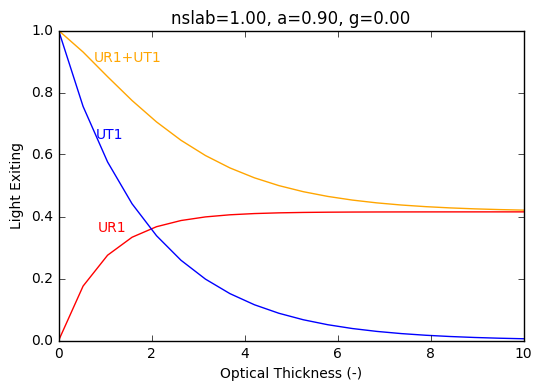

In [41]:
nslab=1.0                  # ignore boundary reflection
nslide=1.0                 # no glass slides above and below the sample
g=0.0                      # isotropic scattering is fine
a = 0.9                    # scattering is 9X absorption
b=np.linspace(0,10,20)     # optical thickness

ur1,ut1,uru,utu = iad.rt(nslab, nslide, a, b, g)

plt.plot(b,ur1,color='red')
plt.plot(b,ut1,color='blue')
plt.plot(b,ur1+ut1,color='orange')
plt.xlabel('Optical Thickness (-)')
plt.ylabel('Light Exiting')
plt.title('nslab=%.2f, a=%.2f, g=%.2f'%(nslab,a,g))

plt.annotate('UR1',xy=(0.85,0.35),color='red')
plt.annotate('UT1',xy=(0.8,0.65),color='blue')

plt.annotate('UR1+UT1',xy=(0.75,0.9),color='orange')

plt.show()

### How thick does a slab need to be before it the reflected light is 99% of an infinitely thick sample?

This number will obviously vary with albedo, but it seems that the number is from 2-5 

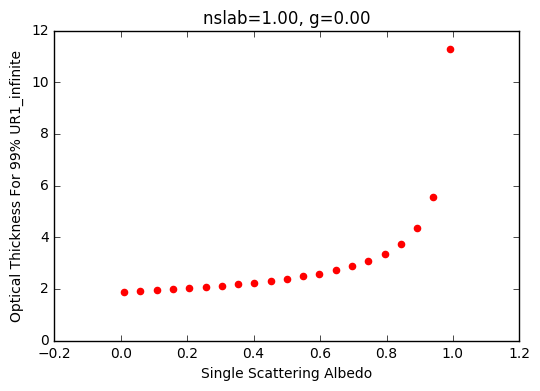

In [54]:

N=21
nslab=1.0                  # ignore boundary reflection
nslide=1.0                 # no glass slides above and below the sample
g=0.0                      # isotropic scattering is fine
a=np.linspace(0.01,0.99,N) # avoid extremes because 
bmin = np.empty(N)

def f(b):
    ur1,ut1,uru,utu = iad.rt(nslab, nslide, aa, b, g)
    return (ur1-ur1_inf*0.99)**2

for i in range(N):
    aa = a[i]
    ur1_inf,ut1_inf,uru_inf,utu_inf = iad.rt(nslab, nslide, aa, 100000, g)
    bmin[i] = optimize.brent(f)  

plt.scatter(a,bmin,color='red')
plt.ylabel('Optical Thickness For 99% UR1_infinite')
plt.xlabel('Single Scattering Albedo')
plt.title('nslab=%.2f, g=%.2f'%(nslab,g))

plt.show()

## Scattering Anisotropy

A normalized scattering function describes the probability density function for the azimuthal and longitudinal angles for light as it is scattered.  If the scattering function has no azimuthal dependence, then the azimuthal angle $\phi$ will be uniformly distributed between 0 and $2\pi$. The probability density function for the longitudinal angle $\theta$ between the current photon direction and the scattered photon direction is found by integrating the scattering function over all azimuthal angles $p(\cos\theta)=p(\mu)$.  For example, the probability density function for isotropic scattering is
$$
p(\mu)={1\over4\pi}
$$

### Henyey-Greenstein scattering function

The probability density function described by the Henyey-Greenstein scattering function is
$$
p(\mu)={1\over4\pi}{1-g^2\over (1+g^2-2g\mu)^{3/2}}
$$

First, need to make sure both scattering functions are normalized to the same overall value.  If we integrate over all $4\pi$ steradians 
$$
\int_{4\pi} p(\theta,\phi)\,d\phi\,\sin\theta d\theta = \int_0^{2\pi}\int_0^\pi p(\theta,\phi)\,d\phi\,\sin\theta d\theta = 2\pi\int_{-1}^1 p(\mu)\,d\mu
$$
or
$$
2\pi\int_{-1}^1 p(\mu)\,d\mu= {1\over2}\int_{-1}^1 {1-g^2\over (1+g^2-2g\mu)^{3/2}}\,d\mu = {1\over2}{2(1-g^2)\over g^2-1}=1
$$
and, of course,
or
$$
{1\over2}\int_{-1}^1 p(\mu)\mu\,d\mu= g
$$


We use it because

* it varies smoothly as $g$ changes from -1 to +1.
* it is old, Henyey and Greenstein, "Diffuse Radiation in the Galaxy," *Astrophysical Journal*, **93**, 70-83, (1941)
* it matches scattering from tissues
* the exact shape often does not matter
* it can be integrated analytically.

The last point has important implications for the adding-doubling method which requires calculation of something called the redistribution function.

In any case, what do these functions look like.

### Plots of Henyey-Greenstein Scattering Functions

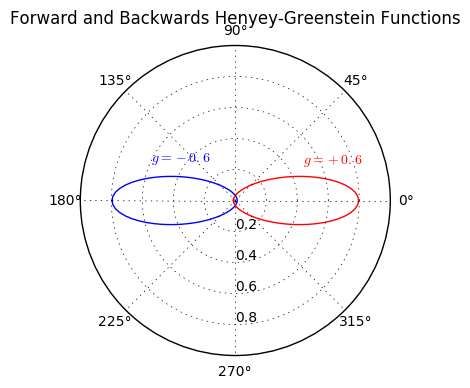

In [92]:
def hg(g,costheta):
    return (1/4/np.pi)*(1-g**2)/(1+g**2-2*g*costheta)**1.5

angles = np.linspace(-180,180,181)*np.pi/180.0
mu = np.cos(angles)
hgscatter = hg(g,mu)

ax = plt.subplot(111, projection='polar')
ax.plot(angles,hg(-0.6,mu),color='blue')
ax.plot(angles,hg( 0.6,mu),color='red')
ax.annotate(r'$g=+0.6$',xy=(0.5,0.5),color='red')
ax.annotate(r'$g= - 0.6$',xy=(2.7,0.6),color='blue')
ax.set_rmax(1)
ax.set_rticks([0.2,0.4,0.6,0.8])
ax.set_rlabel_position(-90)  # get radial labels away from plotted line
ax.set_title('Forward and Backwards Henyey-Greenstein Functions')
plt.show()

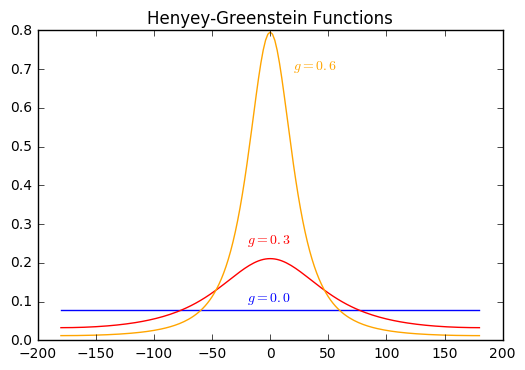

In [97]:
angles = np.linspace(-180,180,181)
mu = np.cos(angles*np.pi/180.0)
hgscatter = hg(g,mu)

ax = plt.subplot(111)
ax.plot(angles,hg( 0.0,mu),color='blue')
ax.plot(angles,hg( 0.3,mu),color='red')
ax.plot(angles,hg( 0.6,mu),color='orange')
ax.annotate(r'$g=0.6$',xy=(20,0.7),color='orange')
ax.annotate(r'$g=0.3$',xy=(-20,0.25),color='red')
ax.annotate(r'$g=0.0$',xy=(-20,0.1),color='blue')

ax.set_title('Henyey-Greenstein Functions')
plt.show()

## Similarity conditions

The idea is that a slab with absorption coefficient $\mu_a$, scattering coefficient $\mu_s$, and scattering anisotropy $g$ can approximated by an equivalent slab with $\mu_s'=\mu_s(1-g)$ and $g=0$.  This means that 
$$
b' = (\mu_a+\mu_s') d = (\mu_a+\mu_s-g\mu_s) d = b - g\mu_s d = b - g a b = b(1-a g)
$$
and 
$$
a' = {\mu_s'\over\mu_a+\mu_s'} = {\mu_sd(1-g)\over b'} = {a b(1-g)\over b'}={a b(1-g)\over b(1-a g)}={a-ag\over 1-a g}
$$
or 
$$
a = {a'\over 1-g+a'g}
$$

Below we see that just setting $g=0$ and using $a'$ results in a pretty good approximation for the total reflectance from a semi-infinite body.

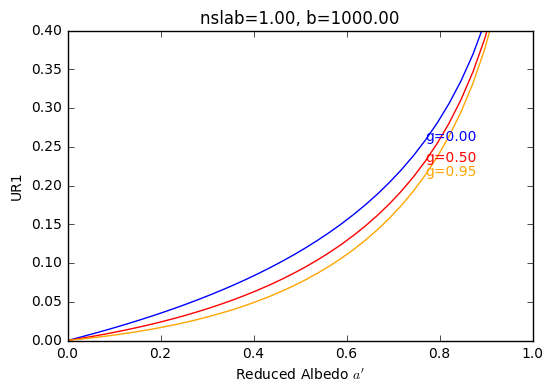

In [106]:
nslab=1.0                  # ignore boundaries
nslide=1.0                 # no glass slides above and below the sample
b=1000                     # relatively thin sample
ap = np.linspace(0,1,40)# albedo varies between 0 and 1
kolor = ['blue','red','orange']
g=[0,0.5,0.95]

for i in range(3):
    a= ap/(1-g[i]+ap*g[i])
    ur1,ut1,uru,utu = iad.rt(nslab, nslide, a, b, g[i])
    plt.plot(ap,ur1,color=kolor[i])
    plt.annotate('g=%.2f'%g[i],xy=(ap[30],ur1[30]),color=kolor[i])

plt.ylim(0,0.4)
plt.xlabel("Reduced Albedo $a'$")
plt.ylabel('UR1')
plt.title('nslab=%.2f, b=%.2f'%(nslab,b))

plt.show()